In [1]:
import numpy as np
import scipy.stats as sps
from scipy.sparse import diags
import random
import matplotlib.pyplot as plt

## Data generation

In [2]:
n = 10000
p0 = np.array([0.2, 0.1, 0.7])
p1 = np.array([0.4, 0.1, 0.5])
X = sps.multinomial(1, p0).rvs(n)

## Algorithm 1
### Implementation

In [3]:
def upper_round(x):
    if np.abs(x - int(x)) < 1e-7:
        return int(x)
    else:
        return int(x) + 1

def sherman_morison(A, u, v):
    n = 1 + v @ A @ u
    return A - ((A @ u)[:, None] * (v @ A)[None, :]) / n

def P(x):
    return x - x.mean()

def M(x, sigma, p0):
    x1 = P(x)
    A = diags([1 / (p0 + sigma)], [0]).toarray()
    A = sherman_morison(A, p0, -p0)
    x2 = A @ x1
    
    return P(x2)

def T_KR(H, sigma, Z, p0, n):
    H_hat = H + Z
    vec = H_hat / n - p0
    M_vec = M(vec, sigma, p0) 
    
    return n * np.dot(vec, M_vec)

def LocalNoiseGOFTest(p0, X, ro, eps, alpha, noise, m=None):
    assert noise in ['gauss', 'laplace']
    n, d = X.shape
    H = np.sum(X, axis=0)
    if noise == 'gauss':
        norm = sps.norm(scale=np.sqrt(1 / ro))
        Z = norm.rvs(d)
        q = T_KR(H, n / ro, Z, p0, n)
        chi2 = sps.chi2(d - 1)
        if q > chi2.ppf(1 - alpha):
            return False
        else:
            return True
        
    elif noise == 'laplace': 
        sigma = 8 * n / eps**2
        scale = eps / 2
        laplace = sps.laplace(scale=scale)
        Z = laplace.rvs(d * n)
        Z = Z.reshape(n, d)
        Z = Z.sum(axis=0).reshape(d)
        q = T_KR(H, sigma, Z, p0, n)
        samples = []
        if m is None:
            m = upper_round(1 / alpha) + 1
        multinomial = sps.multinomial(1, p0)
        for i in range(m):
            H = multinomial.rvs(n).reshape(n, -1)
            H = H.sum(axis=0).reshape(-1)
            Z = laplace.rvs(d * n)
            Z = Z.reshape(n, d)
            Z = Z.sum(axis=0).reshape(-1)
            samples.append(T_KR(H, sigma, Z, p0, n))
            
        samples.sort()
        ind = upper_round((m + 1) * (1 - alpha))
        tau = samples[ind - 1]
        
        if q > tau:
            return False
        else:
            return True

                         

### Experiments

In [4]:
ro = 1000
eps = 1
alpha = 0.05

In [5]:
LocalNoiseGOFTest(p0, X, ro, eps, alpha, 'gauss')

True

In [6]:
LocalNoiseGOFTest(p1, X, ro, eps, alpha, 'gauss')

False

In [7]:
LocalNoiseGOFTest(p0, X, ro, eps, alpha, 'laplace')

True

In [8]:
LocalNoiseGOFTest(p1, X, ro, eps, alpha, 'laplace')

False

## Algorithms 2,3
### Implementation

In [9]:
def GeneralizedRandomizedResponse(x, d, exp_eps):
    un_prob = 1 / (exp_eps - 1 + d)
    ind = np.argmax(x)
    p = np.full((d), un_prob)
    p[ind] *= exp_eps
    x_new = np.zeros(d)
    ind = np.random.choice(np.arange(d), 1, p=p)
    x_new[ind] = 1

    return x_new

def LocalGenRRGOF(p0, X, eps, alpha):
    n, d = X.shape
    exp_eps = np.exp(eps)
    p0_hat = 1 / (exp_eps + d - 1) * (exp_eps * p0 + (1 - p0))
    H_hat = np.zeros(d)
    for i in range(n):
        H_hat += GeneralizedRandomizedResponse(X[i].reshape(-1), d, exp_eps)
    
    q = (H_hat - n * p0_hat)**2 / (n * p0_hat)
    q = q.sum()
    chi2 = sps.chi2(d - 1)
    
    if q > chi2.ppf(1 - alpha):
        return False
    else:
        return True

### Experiments

In [10]:
eps = 1
alpha = 0.05

In [11]:
LocalGenRRGOF(p0, X, eps, alpha)

True

In [12]:
LocalGenRRGOF(p1, X, eps, alpha)

False

## Algorithms 4, 5
### Implementation

In [13]:
def BitFlipLocalRandomizer(x, d, exp_eps_2):
    p = exp_eps_2 / (exp_eps_2 + 1)
    p = (p, 1 - p)
    mask = np.random.choice([1, 0], d, p=p)
    x_new = mask * x + (1 - mask) * (1 - x)
    
    return x_new

def p_wave(p, exp_eps_2):
    res = ((exp_eps_2 - 1) * p + 1) / (exp_eps_2 + 1)
    
    return res

def construct_ksi_inv(p, d, exp_eps_2):
    alpha = (exp_eps_2 - 1) / (exp_eps_2 + 1)
    coef_1 = alpha**2
    coef_2 = exp_eps_2 / ((exp_eps_2 + 1)**2)
    D = coef_1 * p + np.full((d), coef_2)
    D_inv = 1 / D
    ksi_inv = sherman_morison(diags([D_inv], [0]).toarray(), coef_1 * p, -p)
    
    return ksi_inv

def TBitFlip(H_wave, p0, n, d, exp_eps_2):
    ksi_inv = construct_ksi_inv(p0, d, exp_eps_2)
    p0_wave = p_wave(p0, exp_eps_2)
    x1 = H_wave / n - p0_wave
    x2 = P(x1)
    x3 = ksi_inv @ x2
    x4 = P(x3)
    res = n * np.dot(x1, x3)
    
    return res


def LocalBitFlipGOF(p0, X, eps, alpha):
    n, d = X.shape
    H_wave = np.zeros(d)
    exp_eps_2 = np.exp(eps / 2)
    for i in range(n):
        H_wave += BitFlipLocalRandomizer(X[i].reshape(-1), d, exp_eps_2)
        
    q = TBitFlip(H_wave, p0, n, d, exp_eps_2)
    chi2 = sps.chi2(d - 1)
    
    if q > chi2.ppf(1 - alpha):
        return False
    else:
        return True

### Experiments

In [14]:
eps = 1
alpha = 0.05

In [15]:
LocalBitFlipGOF(p0, X, eps, alpha)

True

In [16]:
LocalBitFlipGOF(p1, X, eps, alpha)

False

## Empirical power computation
### Implementation

In [17]:
def NonPrivateChi2(p0, X, alpha):
    n, d = X.shape
    H = X.sum(axis=0)
    q = (H - n * p0)**2 / (n * p0)
    q = q.sum()
    chi2 = sps.chi2(d - 1)
    
    if q > chi2.ppf(1 - alpha):
        return False
    else:
        return True

In [18]:
def calc_tests_powers(d, eps, eta, alpha = 0.05, num_sim=50):
    args_noise_gof = [None, eps, alpha, 'laplace', 999]
    power_noise_gof = empirical_power(LocalNoiseGOFTest, d, eta, num_sim, args_noise_gof)
    args_bit_gof = [eps, alpha]
    power_bit_gof = empirical_power(LocalBitFlipGOF, d, eta, num_sim, args_bit_gof)
    args_genrr_gof = [eps, alpha]
    power_genrr_gof = empirical_power(LocalGenRRGOF, d, eta, num_sim, args_genrr_gof)
    
    return power_noise_gof, power_bit_gof, power_genrr_gof
    
    
def empirical_power(test, d, eta, num_sim, args_test):
    powers = []
    p0 = np.ones(d) / d
    p1 = p0 + eta * np.array([(-1)**(i) for i in range(d)])
    
    for n in np.linspace(1000, 20000, 8).astype(int):
        cnt = 0
        for i in range(num_sim):
            data = sps.multinomial(1, p1).rvs(n)
            cnt += test(p0, data, *args_test)
            
        error_2_type = cnt / num_sim
        power = 1 - error_2_type
        powers.append(power)
        
    return powers

### Experiments

In [19]:
def get_power_plots(upload=True):    
    plots = dict()
    epses = [1, 2, 4]
    d = 4
    eta = 0.01
    num_sim = 50
    args_nonprivate_chi2 = [0.05]
    if upload:
        for eps in [1, 2, 4]:
            plots[('power_noise_gof', eps)] = np.load('power_noise_gof_eps'+str(eps) + '.npy')
            plots[('power_bit_gof', eps)] = np.load('power_bit_gof_eps'+str(eps) + '.npy')
            plots[('power_genrr_gof', eps)] = np.load('power_genrr_gof_eps'+str(eps) + '.npy')

        power_nonprivate_chi2 = np.load('power_nonprivate_chi2.npy')
        plots[('power_nonprivate_chi2', 0)] = power_nonprivate_chi2
        return plots
    
    for eps in epses:
        power_noise_gof, power_bit_gof, power_genrr_gof = calc_tests_powers(d, eps, eta)
        plots[('power_noise_gof', eps)] = power_noise_gof
        plots[('power_bit_gof', eps)] = power_bit_gof
        plots[('power_genrr_gof', eps)] = power_genrr_gof
        np.save('power_noise_gof_eps' + str(i), power_noise_gof)
        np.save('power_bit_gof_eps' + str(i), power_noise_gof)
        np.save('power_genrr_gof_eps' + str(i), power_noise_gof)
        return plots

In [20]:
plots = get_power_plots()

In [21]:
def plot_powers():
    n_list = np.linspace(1000, 20000, 8).astype(int)
    plt.figure(num=None, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')

    colors = {1: 'r', 2: 'g', 4: 'b'}
    for eps in [1, 2, 4]:
        plt.plot(n_list, plots[('power_noise_gof', eps)], c=colors[eps], linestyle='-', label='noise_gof, e=' + str(eps))
        plt.scatter(n_list, plots[('power_noise_gof', eps)], marker='o', c=colors[eps])
        plt.plot(n_list, plots[('power_bit_gof', eps)], c=colors[eps], linestyle=':', label='bit_gof, e=' + str(eps))
        plt.scatter(n_list, plots[('power_bit_gof', eps)], marker='o', c=colors[eps])
        plt.plot(n_list, plots[('power_genrr_gof', eps)], c=colors[eps], linestyle='--', label='genrr_gof, e=' + str(eps))
        plt.scatter(n_list, plots[('power_genrr_gof', eps)], marker='o', c=colors[eps])

    plt.plot(n_list, plots[('power_nonprivate_chi2', 0)], c='black', linestyle='-', label='non_private')
    plt.scatter(n_list, plots[('power_nonprivate_chi2', 0)], marker='o', c='black')
    plt.grid()
    plt.title('Empirical Power Curves for Local DP GOF', fontsize=22)
    plt.legend()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("n", fontsize=20)
    plt.ylabel("power", fontsize=20)
    plt.show()

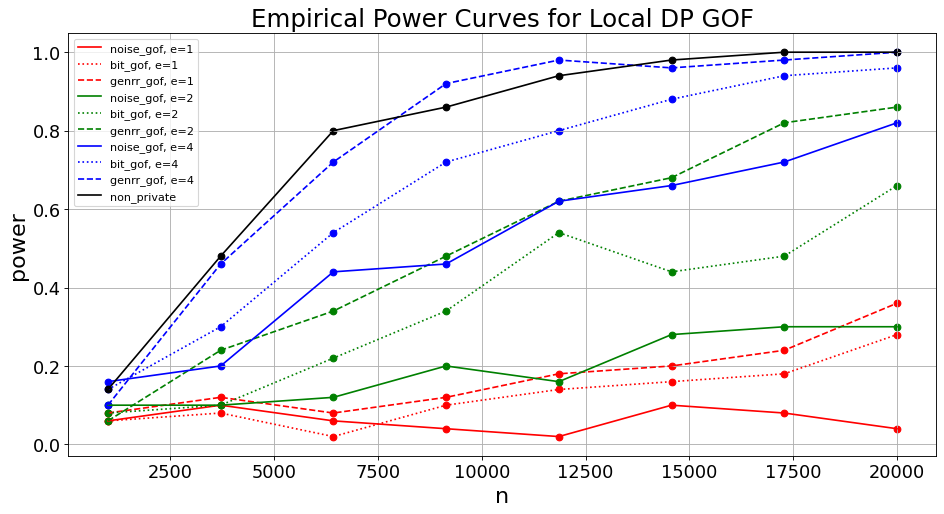

In [22]:
plot_powers()

## Time estimation

In [23]:
def calc_tests_timings(n, d, eps, eta, alpha = 0.05, num_sim=2):
    args_noise_gof = [None, eps, alpha, 'laplace', 999]
    timing_noise_gof = get_timings(LocalNoiseGOFTest, n, d, eta, num_sim, args_noise_gof)
    args_bit_gof = [eps, alpha]
    timing_bit_gof = get_timings(LocalBitFlipGOF, n, d, eta, num_sim, args_bit_gof)
    args_genrr_gof = [eps, alpha]
    timing_genrr_gof = get_timings(LocalGenRRGOF, n, d, eta, num_sim, args_genrr_gof)
    
    return timing_noise_gof, timing_bit_gof, timing_genrr_gof
    
    
def get_timings(test, n_init, d_init, eta, num_sim, args_test):
    timings_by_d = []
    for d in np.linspace(3, 100, 8).astype(int):
        p0 = np.ones(d) / d
        p1 = p0 + eta * np.array([(-1) ** (i) for i in range(d)])
        data = sps.multinomial(1, p1).rvs(n_init)
        t = %timeit -o -q -r 3 test(p0, data, *args_test)
        timings_by_d.append(t.average)
    
    timings_by_n = []
    p0 = np.ones(d_init) / d_init
    p1 = p0 + eta * np.array([(-1) ** (i) for i in range(d_init)])
    for n in np.linspace(1000, 20000, 8).astype(int):
        data = sps.multinomial(1, p1).rvs(n)
        t = %timeit -o -q -r 3 test(p0, data, *args_test)
        timings_by_n.append(t.average)
        
    return timings_by_d, timings_by_n

In [24]:
def get_timing_plots(upload=True):
    d = 4
    n = 1000
    eta = 0.01
    num_sim = 50
    args_nonprivate_chi2 = [0.05]
    timing_plots = dict()
    
    if upload:
        timing_plots[('timing_noise_gof')] = np.load('timing_noise_gof.npy')
        timing_plots[('timing_bit_gof')] = np.load('timing_bit_gof.npy')
        timing_plots[('timing_genrr_gof')] = np.load('timing_genrr_gof.npy')
        timing_plots[('timing_nonprivate_chi2')] = np.load('timing_nonprivate_chi2.npy')
        return timing_plots
    timing_noise_gof, timing_bit_gof, timing_genrr_gof = calc_tests_timings(n, d, 1, eta)
    timing_plots[('timing_noise_gof')] = timing_noise_gof
    timing_plots[('timing_bit_gof')] = timing_bit_gof
    timing_plots[('timing_genrr_gof')] = timing_genrr_gof
    timing_nonprivate_chi2 = get_timings(NonPrivateChi2, n, d, eta, num_sim, args_nonprivate_chi2)
    timing_plots[('timing_nonprivate_chi2')] = timing_nonprivate_chi2
    np.save('timing_nonprivate_chi2', timing_nonprivate_chi2)
    np.save('timing_noise_gof', timing_noise_gof)
    np.save('timing_bit_gof', timing_bit_gof)
    np.save('timing_genrr_gof', timing_genrr_gof)
    return timing_plots

In [25]:
timing_plots = get_timing_plots()

In [26]:
def plot_timings(timing_plots, param='d', mode=1):
    d_list = np.linspace(3, 100, 8).astype(int)
    n_list = np.linspace(1000, 20000, 8).astype(int)
    plt.figure(num=None, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')
    
    if param == 'd':
        if mode == 1:
            plt.plot(d_list, timing_plots[('timing_noise_gof')][0], c='r', linestyle='-', label='noise_gof')
            plt.scatter(d_list, timing_plots[('timing_noise_gof')][0], marker='o', c='r')
        plt.plot(d_list, timing_plots[('timing_bit_gof')][0], c='g', linestyle='-', label='bit_gof')
        plt.scatter(d_list, timing_plots[('timing_bit_gof')][0], marker='o', c='g')
        plt.plot(d_list, timing_plots[('timing_genrr_gof')][0], c='b', linestyle='-', label='genrr_gof')
        plt.scatter(d_list, timing_plots[('timing_genrr_gof')][0], marker='o', c='b')

        plt.plot(d_list, timing_plots[('timing_nonprivate_chi2')][0], c='black', linestyle='-', label='non_private')
        plt.scatter(d_list, timing_plots[('timing_nonprivate_chi2')][0], marker='o', c='black')
        plt.xlabel("d", fontsize=20)
    elif param == 'n':
        if mode == 1:
            plt.plot(n_list, timing_plots[('timing_noise_gof')][1], c='r', linestyle='-', label='noise_gof')
            plt.scatter(n_list, timing_plots[('timing_noise_gof')][1], marker='o', c='r')
        if mode <= 2:
            plt.plot(n_list, timing_plots[('timing_bit_gof')][1], c='g', linestyle='-', label='bit_gof')
            plt.scatter(n_list, timing_plots[('timing_bit_gof')][1], marker='o', c='g')
            plt.plot(n_list, timing_plots[('timing_genrr_gof')][1], c='b', linestyle='-', label='genrr_gof')
            plt.scatter(n_list, timing_plots[('timing_genrr_gof')][1], marker='o', c='b')

        plt.plot(n_list, timing_plots[('timing_nonprivate_chi2')][1], c='black', linestyle='-', label='non_private')
        plt.scatter(n_list, timing_plots[('timing_nonprivate_chi2')][1], marker='o', c='black')
        plt.xlabel("n", fontsize=20)
    
    plt.grid()
    plt.title('Timing Curves for Local DP GOF', fontsize=22)
    plt.legend()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("timing, sec", fontsize=20)
    plt.show()

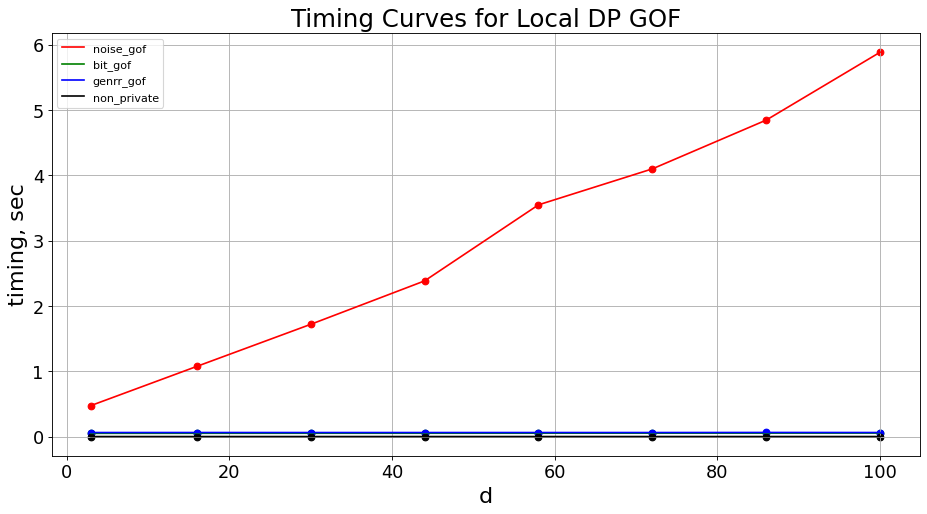

In [27]:
plot_timings(timing_plots, 'd', 1)

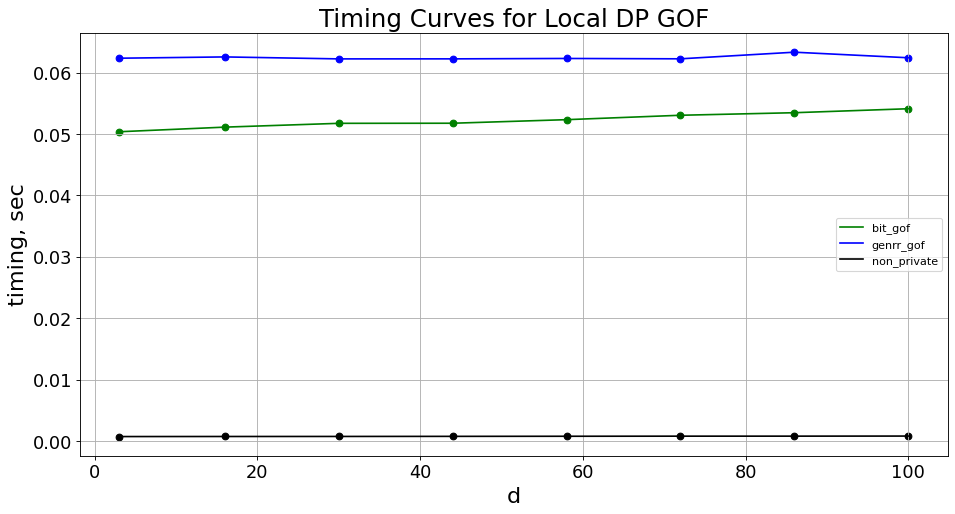

In [28]:
plot_timings(timing_plots, 'd', 2)

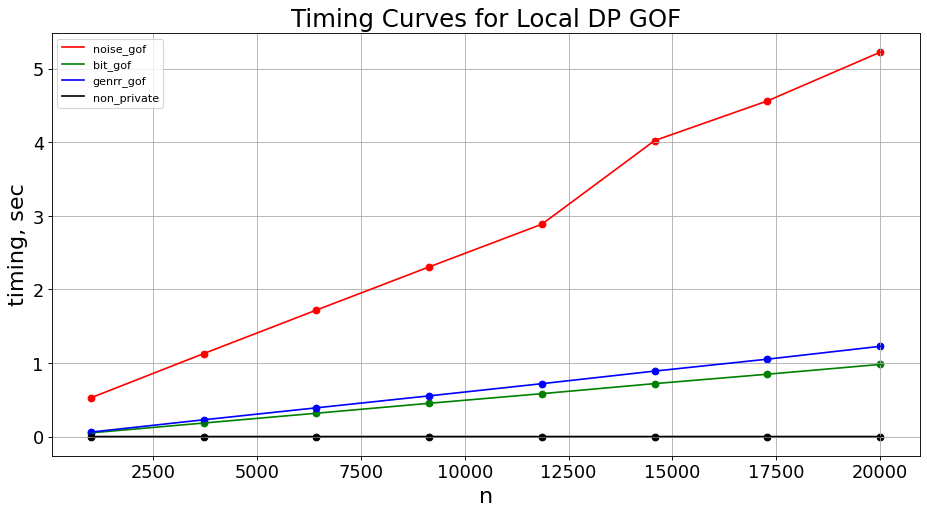

In [29]:
plot_timings(timing_plots, 'n', 1)

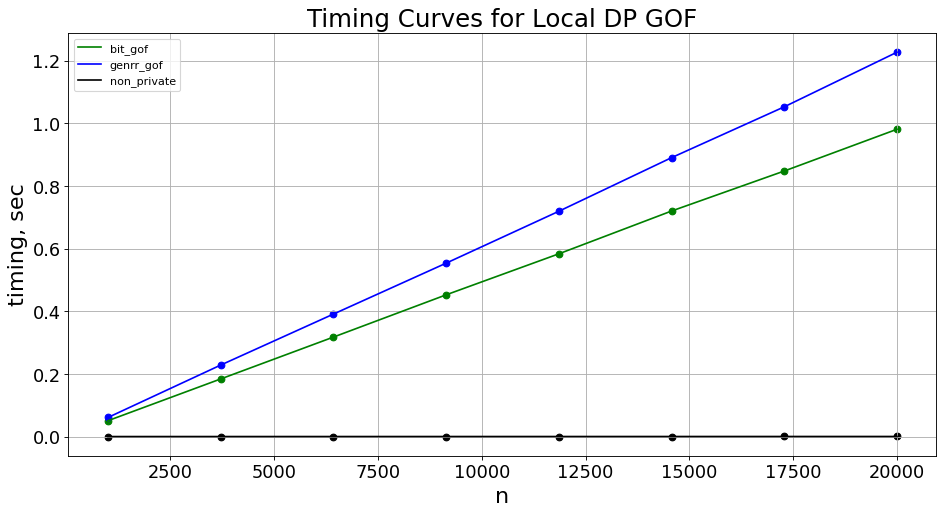

In [30]:
plot_timings(timing_plots, 'n', 2)

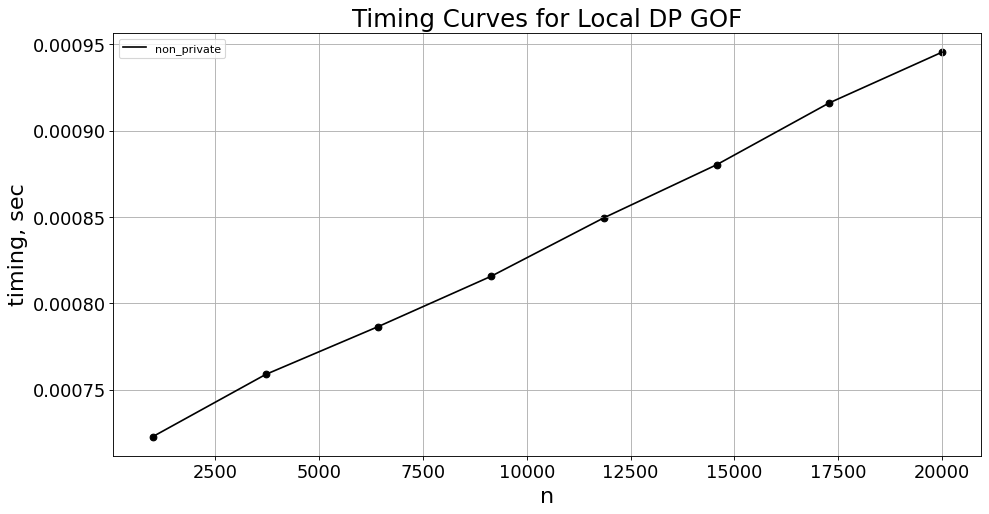

In [31]:
plot_timings(timing_plots, 'n', 3)